# CIRC Annual Conference Year 1 - Data Mining Stream Demonstration
## Data Mining and Machine Learning - Agricultural Resilience and Economic Crop Loss
### Erich Seamon and Paul Gessler
### erichs@uidaho.edu
### http://dmine.io
### http://erich.io

**The Climate Impacts Research Consortium (CIRC)** data mining stream has developed a set of data mining and machine learning processes, in order to provide a basic example of how we might approach climatic impact prediction over space and time.

Our example in this instance is to explore how we might predict economic crop loss over space and time, using data that is extracted from differing sources, transformed, and combined with a response variable that is a approximation of economic crop loss, in dollars. This notebook provides an overview of our steps for this example, which include:


**1. Demo Overview. ** An overview of the problem, summary of the datasets involved.
   <br> </br> <br></br>
**2. Data transformation.**  What steps do we need to take to transform and combine data into a form that is ready to machine learning techniques?
    <br></br><br></br>
**3. Exploratory Data Analysis.**  After transforming the data, a matrix of all values is generated.  From this dataset, what EDA can we perform that will help us to better understand our hypothesis/es?
    <br></br><br></br>
**4. Machine learning model generation, optimization.**  Which model works best?
   <br></br><br></br>
**5. Model Instantiation. ** Apply most optimized model to a python API for enabling prediction requests.


## 1. Demo Overview: Overview of the problem, and summary of datasets

### Food Resilience NOAA key points (adapted from Third National Climate Assessment - Hatfield, et al, 2014)


 - Climate disruptions to agricultural production have increased over the past 40 years and are projected to increase over the next 25 years. Farmers and ranchers will likely need to increase their rate of innovation and adaptation to keep pace with this projected change.
 
 - Crop and livestock production in many agricultural regions will likely decline due to weeds, diseases, insects, and climate-related stresses.
 
 - The rising incidence of extreme weather—including heat waves, drought, and very heavy precipitation—will increasingly impact crop and livestock productivity.
 
 - Climate-related changes in crop yields and food prices as well as impacts on food processing, storage, and distribution systems can impact food security.
 
 
 ### Problem question: Can we perform data mining techniques to assemble food resilience data - and construct a machine learning model that predicts economic crop loss?
 
 

## Datasets and data sources used as part of the analysis

To be straightforward for the sake of demonstration - we are using two core datasets:
    
- **University of Idaho GRIDMET data.**  Since our CIRC project uses UIdaho GRIDMET/MACA data for a portion of our research efforts, i thought using this as an input dataset might be appropriate.  As a note, we can easily add variables to this grouping that might be from other sources.
- **USDA Economic Crop Loss data.**  The USDA's Risk Management Agency summarizes economic crop loss insurance claims at a county and monthly level, going back to 1980.  This dataset gives a historical view of crop loss, and to a more generalized degree, overall economic food security.  

Transforming both datasets to be spatially and geographically normalized (at the county/monthly/commodity level), we can then integrate into one big matrix.

## 2. Data Transformation

In [ ]:
Data transformation was done in R.  The following R script was used to 

In [8]:
import PIL
from scipy import stats
import os,sys
import numpy as np
from PIL import Image
from urllib2 import urlopen
import os,sys
from PIL import Image

In [ ]:
basewidth = 1000
img = Image.open(urlopen("http://dmine.io/wp-content/uploads/2016/06/Screen-Shot-2016-06-10-at-7.35.10-PM.png"))
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
img.save("dmine-website-2016.jpg")
jpgfile = Image.open("dmine-website-2016.jpg")
jpgfile

# Machine Learning Demonstration - CIRC DMINE AG



## Loading libraries and importing data.  

This dataset is a ~14000 record dataset of monthly crop loss and acreage values, that has been integrated with GRIDMET daily data - summarized to monthly, and at a county geographic scale - for only Washington.

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
os.chdir("/agmesh-scenarios/scenario_52177/")
train = pd.read_csv('2001_2015_usda_gridmet_WA_machine', index_col=0)
%matplotlib nbagg

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
# create feature matrix (X)
all_cols = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax', 'loss']
feature_cols = ['bi', 'pr', 'pdsi', 'pet', 'erc', 'th', 'vs', 'fm1000', 'fm100', 'srad', 'sph', 'tmmx', 'tmmn', 'rmin', 'rmax']

X = train[feature_cols]

# create response vector (y)
y = train.loss
y = pd.Series.to_frame(y)

train = train[all_cols]

## Set up training and testing 

In [58]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Building a regression decision tree in scikit-learn

In [21]:
# instantiate a DecisionTreeRegressor (with random_state=1)
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1, splitter='best')

In [22]:
# use 10 fold CV to estimate the RMSE for this model
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

423607.46564580017

## Tuning regression tree

Let's try to reduce the RMSE by tuning the **max_depth** parameter:

In [23]:
# try different values one-by-one
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

341391.80108382751

## Looping thru a set number of max_depths to see the optimum level

In [24]:
# list of values to try
max_depth_range = range(1, 20)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

<IPython.core.display.Javascript object>


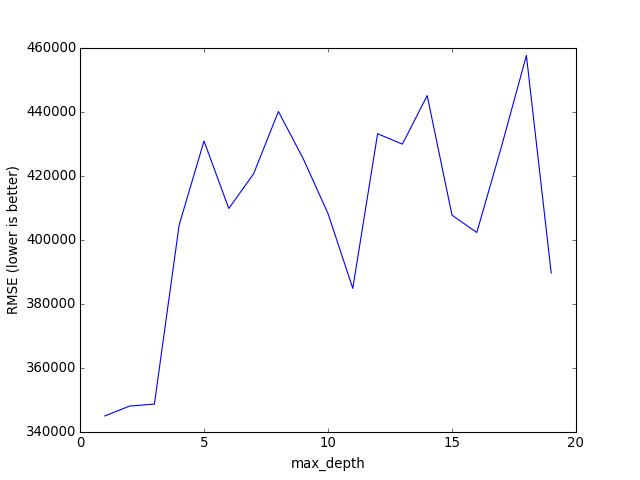

In [25]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [26]:
# max_depth=3 was best, so fit a tree using that parameter
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=1, splitter='best')

## Decision Tree Feature Importance determination

In [27]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,bi,0.000000
1,pr,0.000000
2,pdsi,0.000000
3,pet,0.000000
4,erc,0.000000
5,th,0.443436
6,vs,0.124707
7,fm1000,0.000000
8,fm100,0.382797
9,srad,0.013721


In examining the above feature importance table, these variables appear to be the most significant with regards to crop loss:

- th - wind speed
- vs - wind direction
- fm100 - 100-hour dead fuel moisture

    
    

In [6]:
sig_feature_cols = ['th', 'vs', 'fm100']
X_sig = train[feature_cols]


## Creating a tree diagram

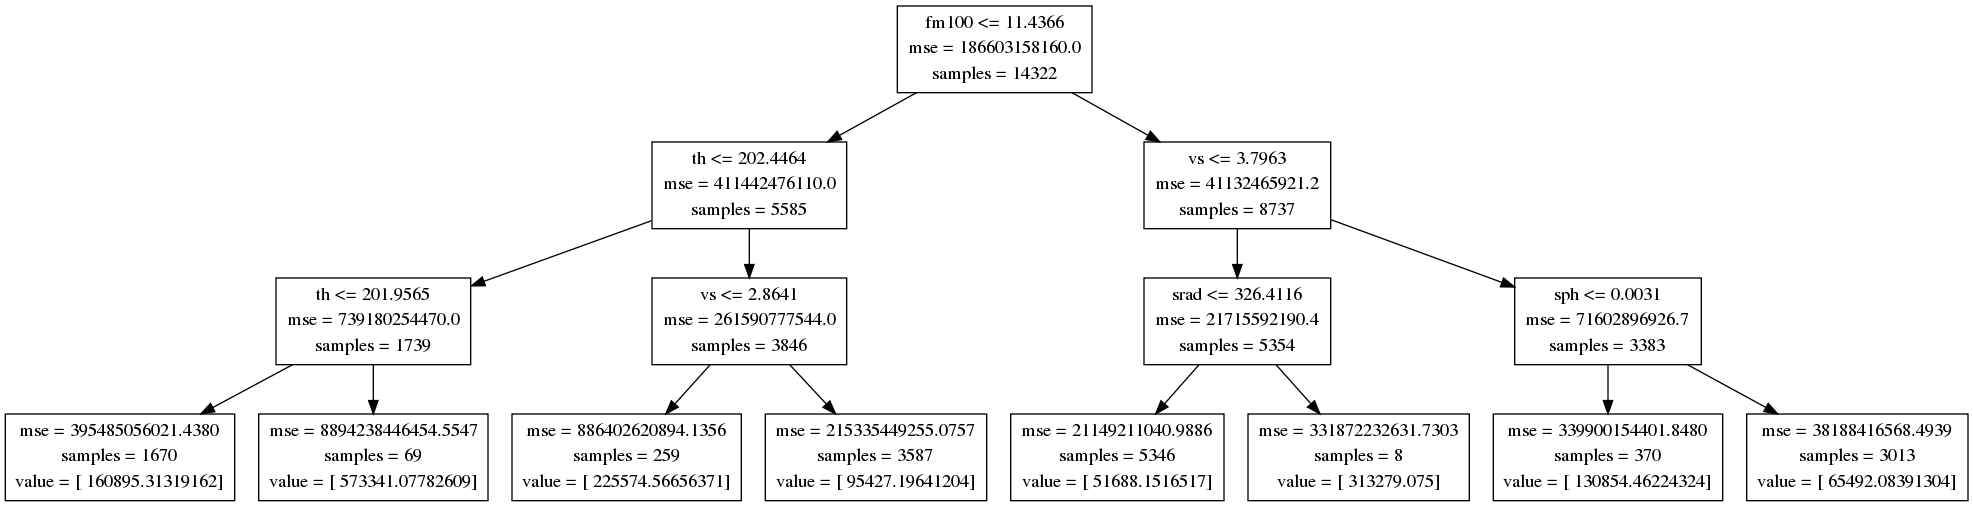

In [28]:
# create a Graphviz file
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_ag.dot', feature_names=feature_cols)

from IPython.display import Image
Image(filename='tree_ag.png')
# At the command line, run this to convert to PNG:
# dot -Tpng tree_vehicles.dot -o tree_vehicles.png

## Making predictions for the testing data

In [20]:
# read the testing data
#url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_test.csv'
#test = pd.read_csv(url)
#test['vtype'] = test.vtype.map({'car':0, 'truck':1})
#test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


**Question:** Using the tree diagram above, what predictions will the model make for each observation?

In [38]:
# use fitted model to make predictions on testing data
#X_test = combined.df[feature_cols]
#y_test = test.price
y_pred = treereg.predict(X_test)
y_pred

array([  65492.08391304,   51688.1516517 ,  225574.56656371, ...,
         51688.1516517 ,  160895.31319162,   51688.1516517 ])

In [39]:
from sklearn import metrics
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

ValueError: Found arrays with inconsistent numbers of samples: [   3 3581]

In [35]:
# calculate RMSE for your own tree!
#y_test = [3000, 6000, 12000]
#y_pred = [0, 0, 0]
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

7937.2539331937714

## Random Forest

Automatically created module for IPython interactive environment


/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>


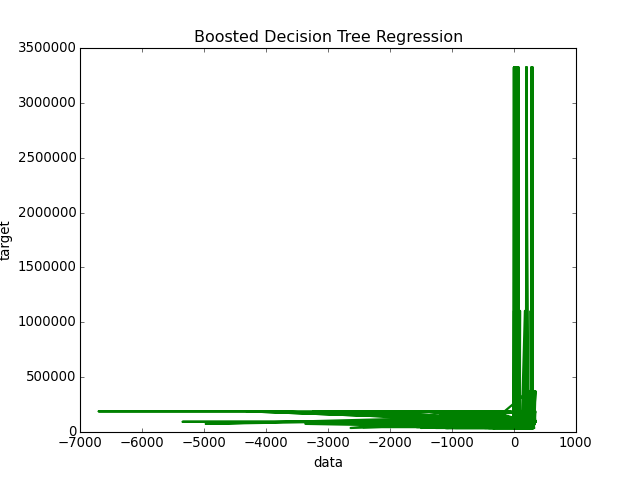

In [67]:
print(__doc__)

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create the dataset
rng = np.random.RandomState(1)


# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Plot the results
plt.figure()
#plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
#plt.plot(X, y_2, c="r", label="n_estimators=300", linewidth=.5)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
#plt.legend()
plt.show()